C:\Users\user\AppData\Local\Temp\ipykernel_23720\4249161645.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\4249161645.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\4249161645.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

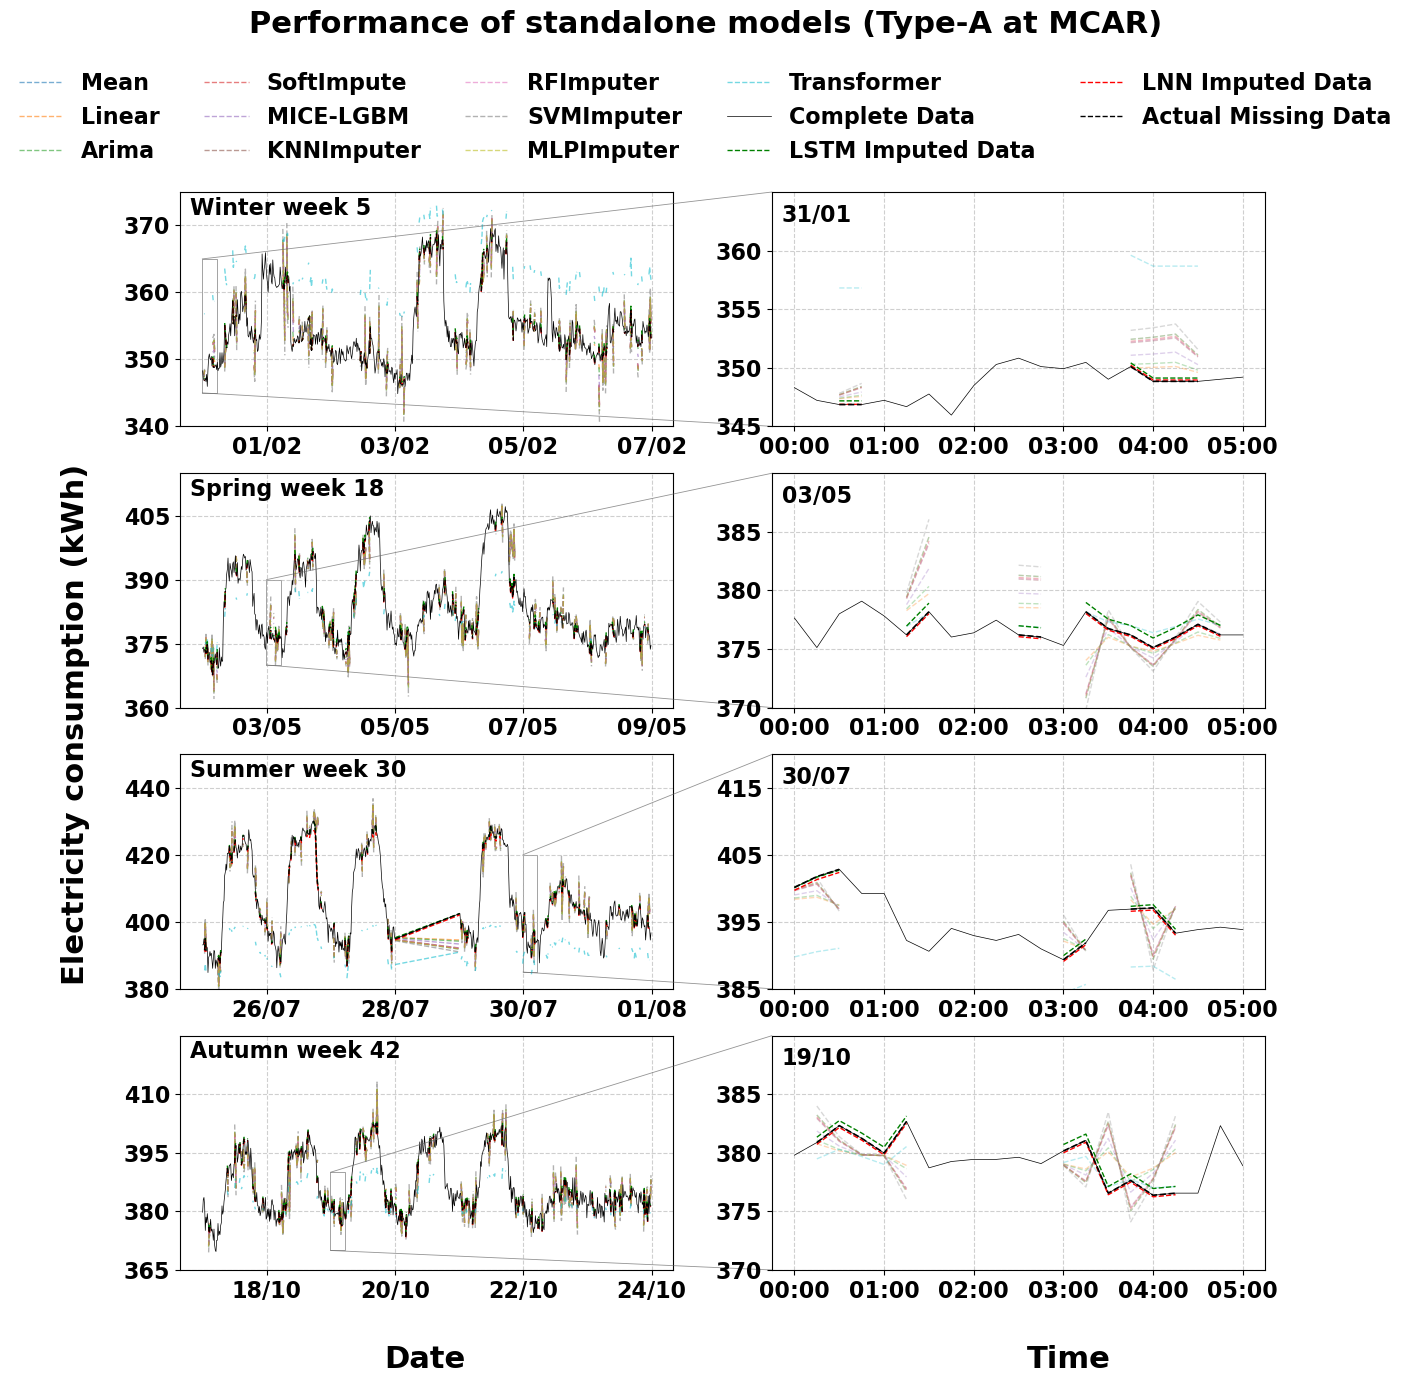

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\501_a1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')

# Set the datetime as the index for easier resampling and manipulation
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# List of background models to plot with transparency
background_models = [
    'Mean', 'Linear', 'Arima', 'SoftImpute', 'MICE-LGBM',
    'KNNImputer', 'RFImputer', 'SVMImputer', 'MLPImputer', 'Transformer'
]

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (340, 375),
    'Spring week 18': (360, 415),
    'Summer week 30': (380, 450),
    'Autumn week 42': (365, 425)
}
y_intervals_weekly = {
    'Winter week 5': 10,
    'Spring week 18': 15,
    'Summer week 30': 20,
    'Autumn week 42': 15
}

y_limits_daily = {
    'Winter week 5': (345, 365),
    'Spring week 18': (370, 390),
    'Summer week 30': (385, 420),
    'Autumn week 42': (370, 390)
}
y_intervals_daily = {
    'Winter week 5': 5,
    'Spring week 18': 5,
    'Summer week 30': 10,
    'Autumn week 42': 5
}

# Define a mapping for each season to plot weekly data and daily data from selected hours (00:00 to 05:00)
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# Parameters to adjust the position and font size of the season labels in the left panel
season_label_params = {
    'x_position': 0.02,  # Horizontal position
    'y_position': 0.98,  # Vertical position
    'font_size': 16      # Font size
}

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)  # Reduce space between the right and left panels

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot (left panel)
    for model in background_models:
        if model in seasonal_data.columns:
            weekly_ax.plot(seasonal_data.index, seasonal_data[model], '--', alpha=0.6, linewidth=1, label=model)

    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=1, label='Actual Missing Data')

    weekly_ax.text(season_label_params['x_position'], season_label_params['y_position'], season,
                   transform=weekly_ax.transAxes, fontsize=season_label_params['font_size'], fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot (right panel)
    daily_data = seasonal_data.copy()
    daily_data['day'] = daily_data.index.date
    daily_non_nan_counts = daily_data.groupby('day')['actual data'].apply(lambda x: x.notna().sum())
    selected_day = daily_non_nan_counts.idxmax()

    selected_day_data = seasonal_data[seasonal_data.index.date == selected_day].between_time('00:00', '05:00')
    for model in background_models:
        if model in selected_day_data.columns:
            daily_ax.plot(selected_day_data.index, selected_day_data[model], '--', alpha=0.3, linewidth=1, label=model)

    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='ytrue')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Data')

    # Insert the date inside the daily plot (format: Day-Month)
    daily_ax.text(0.02, 0.95, selected_day.strftime('%d/%m'), transform=daily_ax.transAxes, fontsize=16, fontweight='bold', verticalalignment='top', horizontalalignment='left')
    daily_ax.grid(True, linestyle='--', alpha=0.6)

    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    # Add inset connection lines between weekly and daily plots with shorter length
    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

# Bold shared labels and legend
fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')

fig.suptitle('Performance of standalone models (Type-A at MCAR)', fontsize=22, fontweight='bold', y=1.01)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0.07, 0.90, 1, 1])

# Save the plot
output_path_svg = r'C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xa1_mcar_all_models.svg'
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_23720\3679830409.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3679830409.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3679830409.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

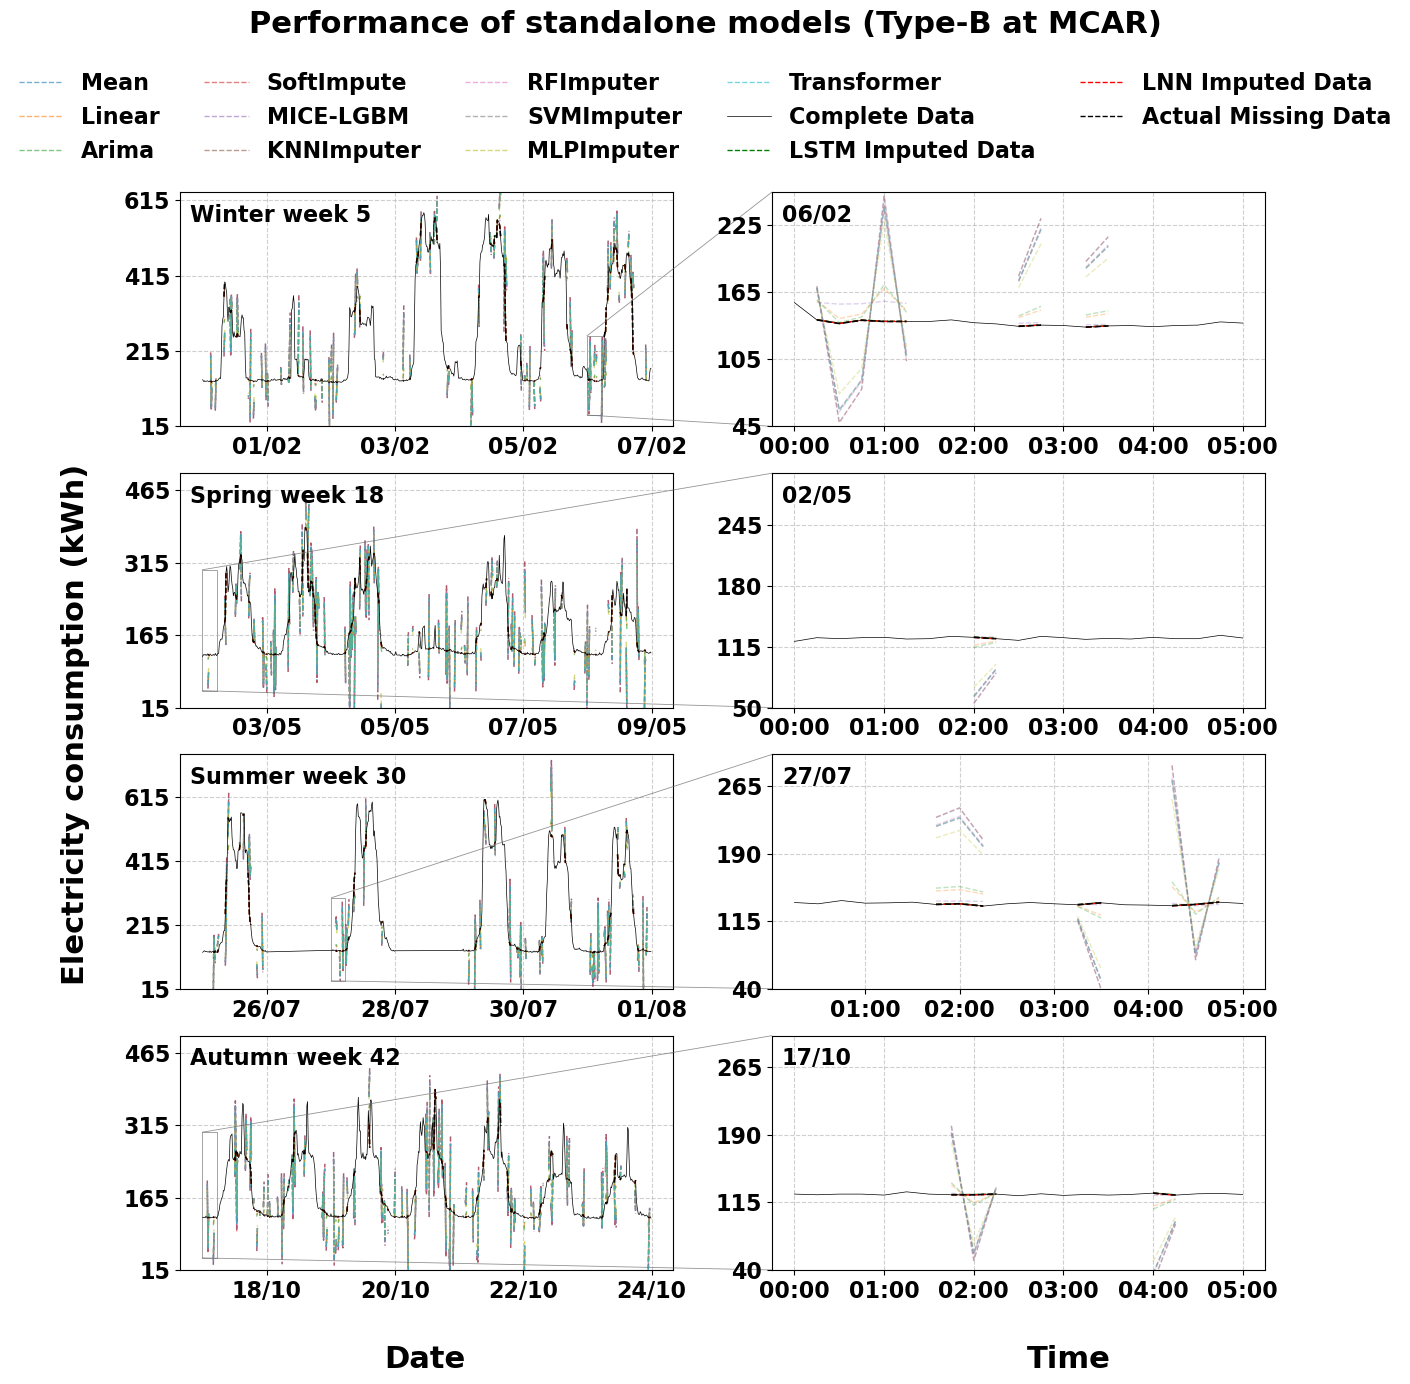

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\502_b1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# List of background models to plot with transparency
background_models = [
    'Mean', 'Linear', 'Arima', 'SoftImpute', 'MICE-LGBM',
    'KNNImputer', 'RFImputer', 'SVMImputer', 'MLPImputer', 'Transformer'
]

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (15, 637.5),
    'Spring week 18': (15, 500),
    'Summer week 30': (15, 750),
    'Autumn week 42': (15, 500)
}
y_intervals_weekly = {
    'Winter week 5': 200,
    'Spring week 18': 150,
    'Summer week 30': 200,
    'Autumn week 42': 150
}

y_limits_daily = {
    'Winter week 5': (45, 255),
    'Spring week 18': (50, 300),
    'Summer week 30': (40, 300),
    'Autumn week 42': (40, 300)
}
y_intervals_daily = {
    'Winter week 5': 60,
    'Spring week 18': 65,
    'Summer week 30': 75,
    'Autumn week 42': 75
}

# Define specific dates for the daily plots in each season
daily_dates = {
    'Winter week 5': None,  # Use the day with the most data
    'Spring week 18': '2022-05-02',
    'Summer week 30': '2022-07-27',
    'Autumn week 42': '2022-10-17'
}

# Define a mapping for each season to plot weekly data and daily data from selected hours (00:00 to 05:00)
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot (left panel)
    for model in background_models:
        if model in seasonal_data.columns:
            weekly_ax.plot(seasonal_data.index, seasonal_data[model], '--', alpha=0.6, linewidth=1, label=model)

    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=1, label='Actual Missing Data')

    weekly_ax.text(0.02, 0.95, season, transform=weekly_ax.transAxes, fontsize=16, fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot (right panel)
    if daily_dates[season]:
        selected_day_data = seasonal_data[seasonal_data.index.date == pd.to_datetime(daily_dates[season]).date()].between_time('00:00', '05:00')
        selected_day = daily_dates[season]
    else:
        daily_data = seasonal_data.copy()
        daily_data['day'] = daily_data.index.date
        daily_non_nan_counts = daily_data.groupby('day')['actual data'].apply(lambda x: x.notna().sum())
        selected_day = daily_non_nan_counts.idxmax()
        selected_day_data = seasonal_data[seasonal_data.index.date == selected_day].between_time('00:00', '05:00')

    for model in background_models:
        if model in selected_day_data.columns:
            daily_ax.plot(selected_day_data.index, selected_day_data[model], '--', alpha=0.3, linewidth=1, label=model)

    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='ytrue')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Data')

    formatted_date = pd.Timestamp(selected_day).strftime('%d/%m')
    daily_ax.text(0.02, 0.95, formatted_date, transform=daily_ax.transAxes, fontsize=16, fontweight='bold', verticalalignment='top', horizontalalignment='left')

    daily_ax.grid(True, linestyle='--', alpha=0.6)
    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')
fig.suptitle('Performance of standalone models (Type-B at MCAR)', fontsize=22, fontweight='bold', y=1.01)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0.07, 0.90, 1, 1])

output_path_svg = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xb1_all_models_mcar.svg"
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23720\3318650408.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3318650408.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3318650408.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

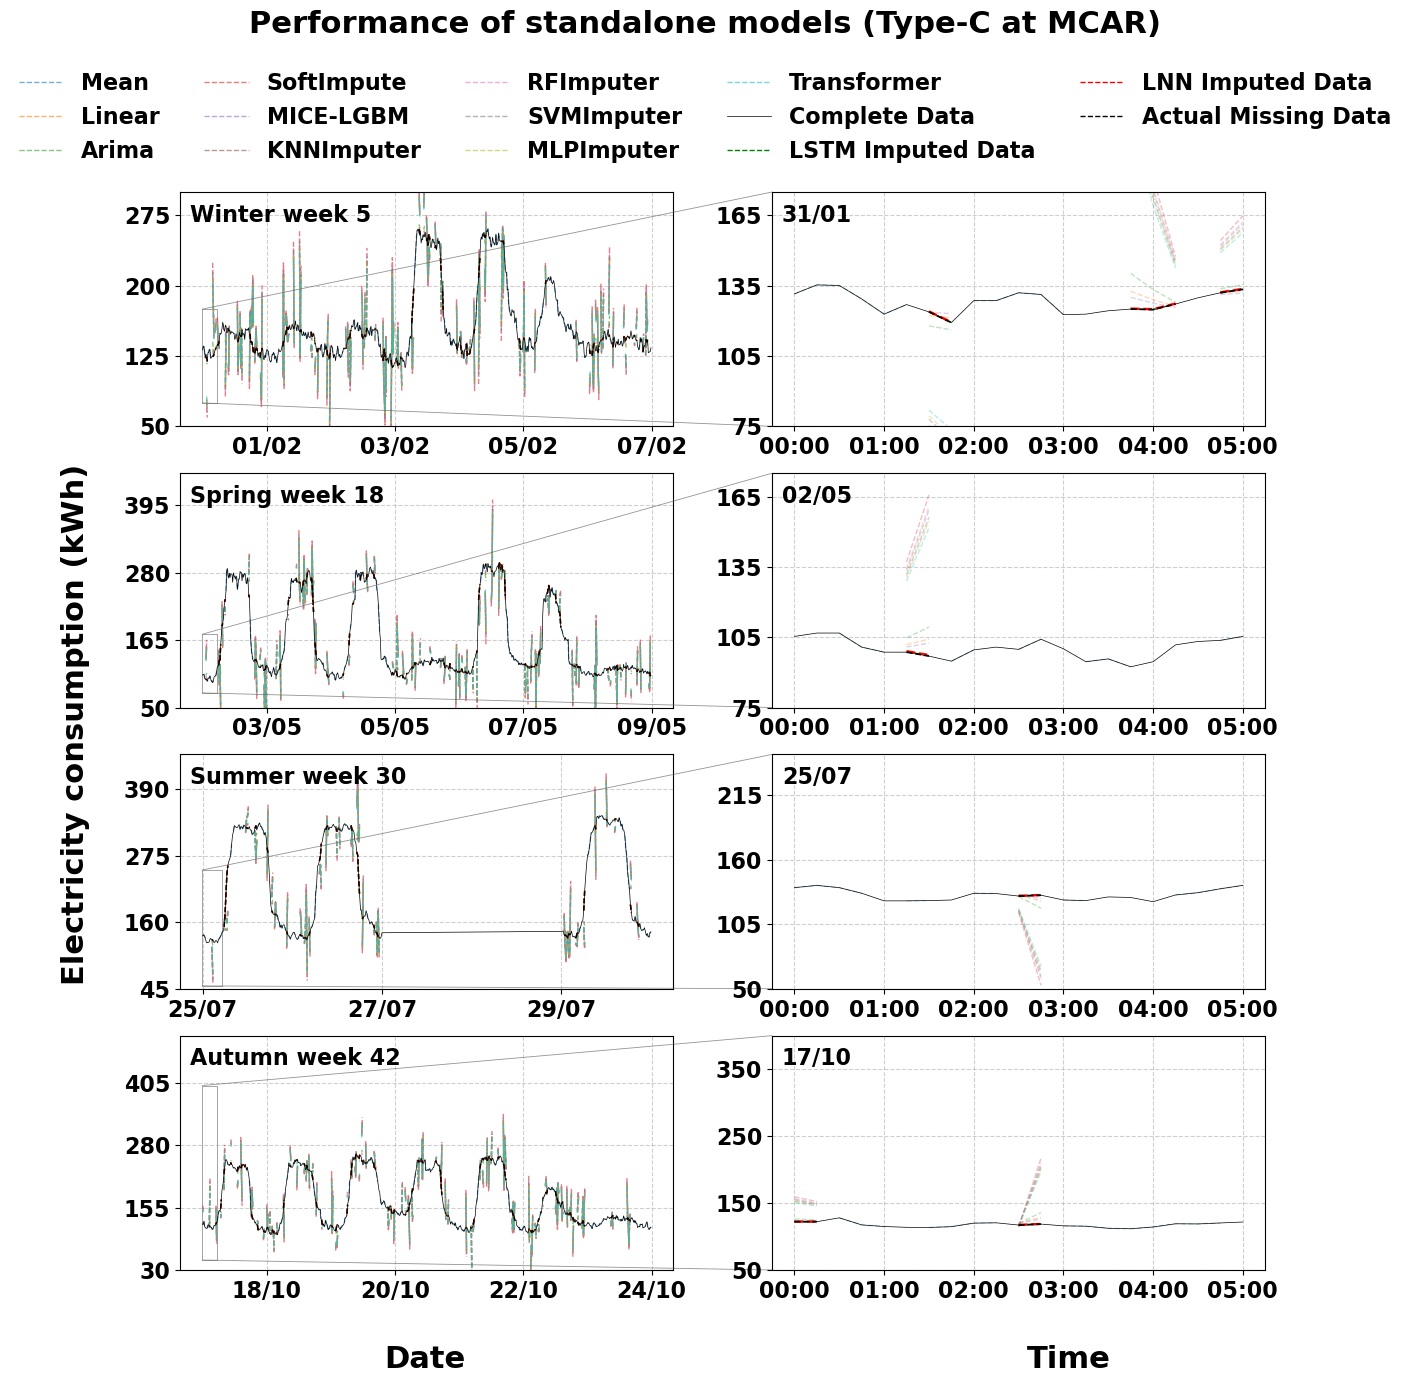

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\505_c1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (50, 300),
    'Spring week 18': (50, 450),
    'Summer week 30': (45, 450),
    'Autumn week 42': (30, 500)
}
y_intervals_weekly = {
    'Winter week 5': 75,
    'Spring week 18': 115,
    'Summer week 30': 115,
    'Autumn week 42': 125
}
y_limits_daily = {
    'Winter week 5': (75, 175),
    'Spring week 18': (75, 175),
    'Summer week 30': (50, 250),
    'Autumn week 42': (50, 400)
}
y_intervals_daily = {
    'Winter week 5': 30,
    'Spring week 18': 30,
    'Summer week 30': 55,
    'Autumn week 42': 100
}

# Define specific dates for the daily plots
daily_dates = {
    'Winter week 5': '2022-01-31',
    'Spring week 18': '2022-05-02',
    'Summer week 30': '2022-07-25',
    'Autumn week 42': '2022-10-17'
}

# Define a mapping for each season to plot weekly data and daily data from selected hours
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# List of background models
background_models = [
    'Mean', 'Linear', 'Arima', 'SoftImpute', 'MICE-LGBM',
    'KNNImputer', 'RFImputer', 'SVMImputer', 'MLPImputer', 'Transformer'
]

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot
    for model in background_models:
        if model in seasonal_data.columns:
            weekly_ax.plot(seasonal_data.index, seasonal_data[model], '--', alpha=0.6, linewidth=1, label=model)

    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=1, label='Actual Missing Data')

    weekly_ax.text(0.02, 0.95, season, transform=weekly_ax.transAxes, fontsize=16, fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot with specified time range and date
    selected_date = pd.to_datetime(daily_dates[season])
    selected_day_data = seasonal_data[seasonal_data.index.date == selected_date.date()].between_time('00:00', '05:00')

    for model in background_models:
        if model in selected_day_data.columns:
            daily_ax.plot(selected_day_data.index, selected_day_data[model], '--', alpha=0.3, linewidth=1, label=model)

    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='ytrue')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1.7, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Data')

    daily_ax.text(0.02, 0.95, selected_date.strftime('%d/%m'), transform=daily_ax.transAxes, fontsize=16, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left')

    daily_ax.grid(True, linestyle='--', alpha=0.6)
    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    # Add inset connection lines
    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

# Common y-axis label
fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')
fig.suptitle('Performance of standalone models (Type-C at MCAR)', fontsize=22, fontweight='bold', y=1.01)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0.07, 0.90, 1, 1])

# Save the plot
output_path_svg = r'C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xc1_all_models_mcar.svg'
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23720\3644379532.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3644379532.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3644379532.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

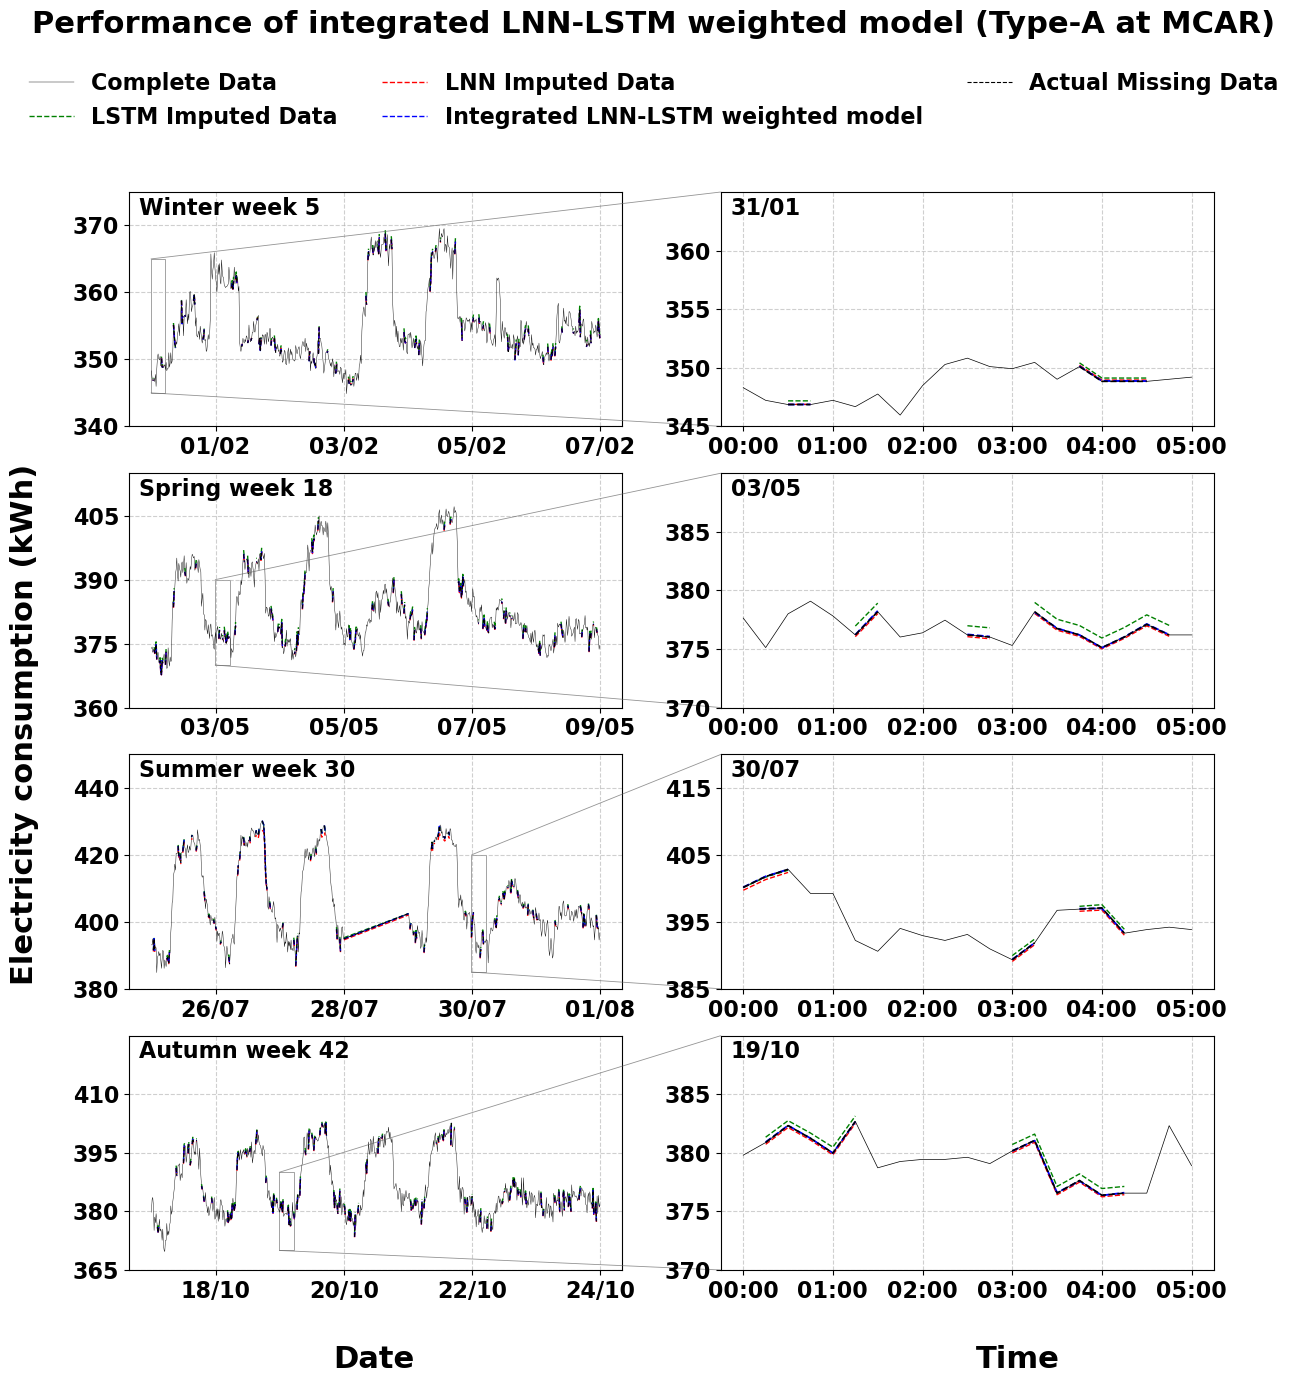

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\501_a1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (340, 375),
    'Spring week 18': (360, 415),
    'Summer week 30': (380, 450),
    'Autumn week 42': (365, 425)
}
y_intervals_weekly = {
    'Winter week 5': 10,
    'Spring week 18': 15,
    'Summer week 30': 20,
    'Autumn week 42': 15
}

y_limits_daily = {
    'Winter week 5': (345, 365),
    'Spring week 18': (370, 390),
    'Summer week 30': (385, 420),
    'Autumn week 42': (370, 390)
}
y_intervals_daily = {
    'Winter week 5': 5,
    'Spring week 18': 5,
    'Summer week 30': 10,
    'Autumn week 42': 5
}

# Define a mapping for each season to plot weekly data and daily data from selected hours (00:00 to 05:00)
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# Parameters to adjust the position and font size of the season labels in the left panel
season_label_params = {
    'x_position': 0.02,  # Horizontal position
    'y_position': 0.98,  # Vertical position
    'font_size': 16      # Font size
}

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]

    # Interpolate missing values for 'ytrue'
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot (left panel)
    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.3, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1, label='Integrated LNN-LSTM weighted model')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=0.8, label='Actual Missing Data')

    weekly_ax.text(season_label_params['x_position'], season_label_params['y_position'], season,
                   transform=weekly_ax.transAxes, fontsize=season_label_params['font_size'], fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot (right panel)
    daily_data = seasonal_data.copy()
    daily_data['day'] = daily_data.index.date
    daily_non_nan_counts = daily_data.groupby('day')['actual data'].apply(lambda x: x.notna().sum())
    selected_day = daily_non_nan_counts.idxmax()

    selected_day_data = seasonal_data[seasonal_data.index.date == selected_day].between_time('00:00', '05:00')
    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='ytrue')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1.3, label='Integrated LNN-LSTM weighted model')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Data')

    # Display only day and month in the date label
    daily_ax.text(0.02, 0.98, selected_day.strftime('%d/%m'), transform=daily_ax.transAxes, fontsize=16, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left')
    daily_ax.grid(True, linestyle='--', alpha=0.6)
    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    # Add inset connection lines
    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

# Common y-axis label
fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')

fig.suptitle('Performance of integrated LNN-LSTM weighted model (Type-A at MCAR)', fontsize=22, fontweight='bold', y=1.01)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0.07, 0.90, 1, 1])

# Save the plot
output_path_svg = r'C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xa1_mcar.svg'
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23720\3395370674.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3395370674.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\3395370674.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

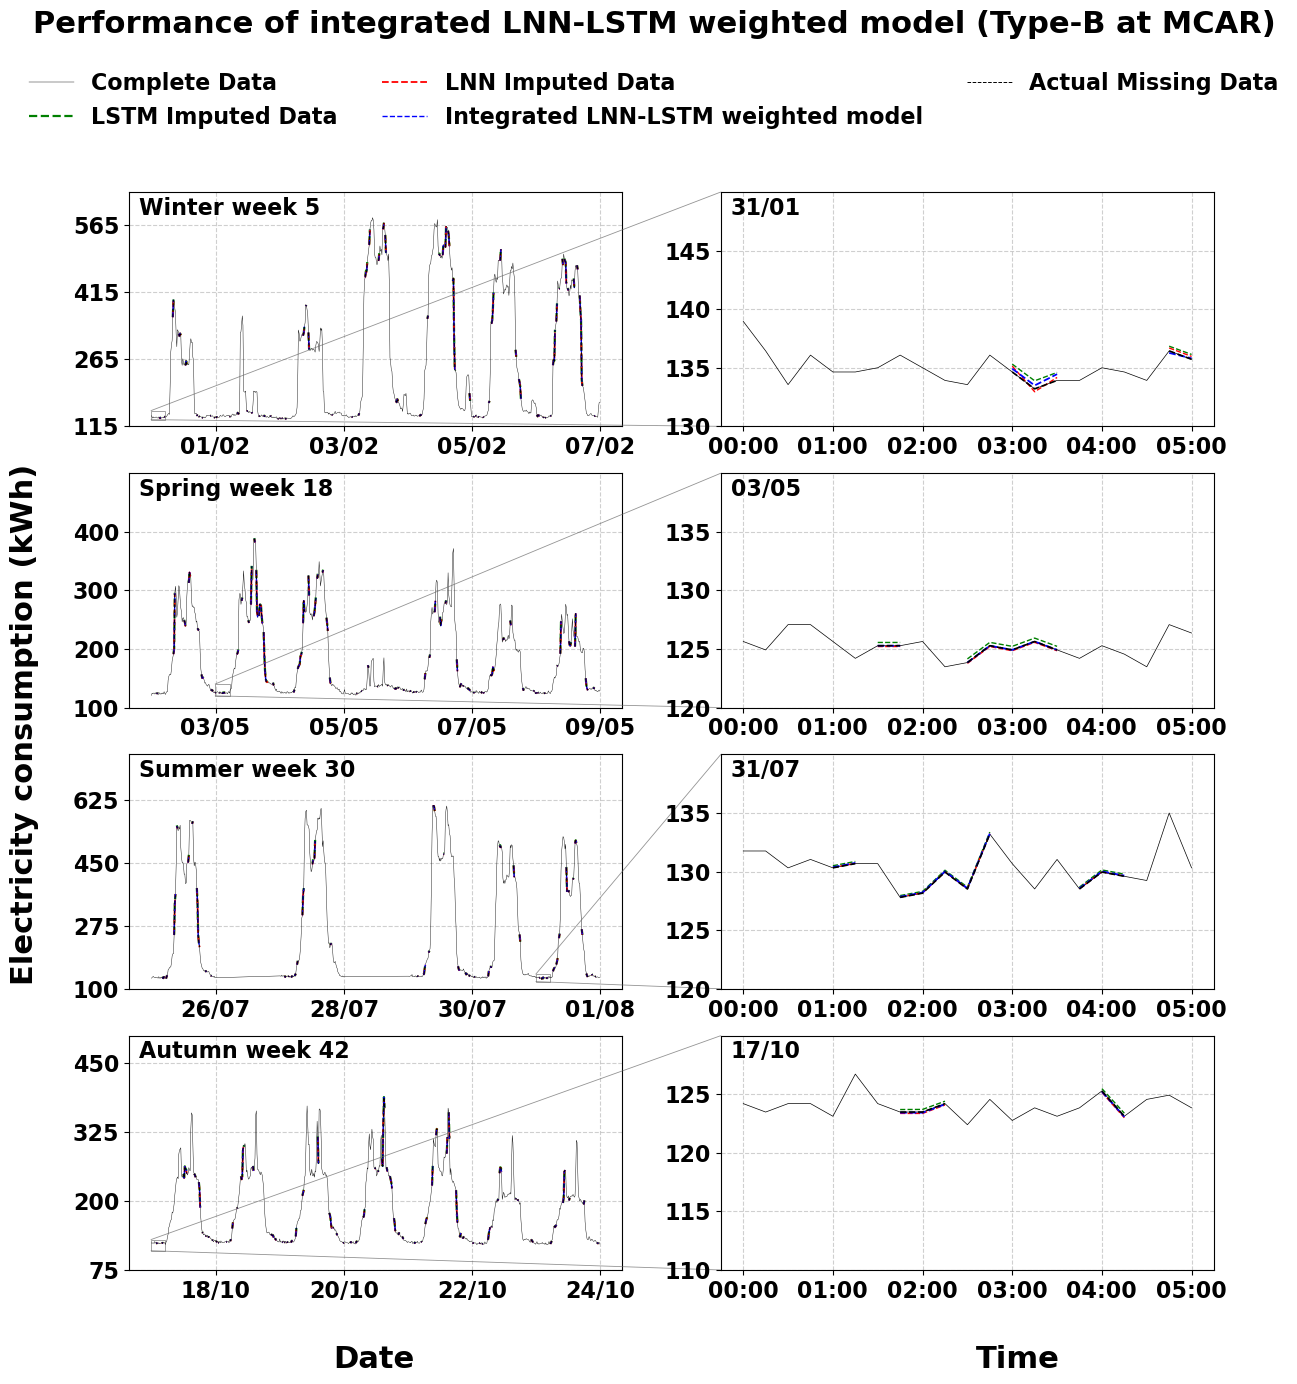

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\502_b1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (115, 640),
    'Spring week 18': (100, 500),
    'Summer week 30': (100, 750),
    'Autumn week 42': (75, 500)
}
y_intervals_weekly = {
    'Winter week 5': 150,
    'Spring week 18': 100,
    'Summer week 30': 175,
    'Autumn week 42': 125
}
y_limits_daily = {
    'Winter week 5': (130, 150),
    'Spring week 18': (120, 140),
    'Summer week 30': (120, 140),
    'Autumn week 42': (110, 130)
}
y_intervals_daily = {
    'Winter week 5': 5,
    'Spring week 18': 5,
    'Summer week 30': 5,
    'Autumn week 42': 5
}

# Define specific dates for the daily plots in each season
custom_dates = {
    'Winter week 5': '2022-01-31',
    'Spring week 18': '2022-05-03',
    'Summer week 30': '2022-07-31',
    'Autumn week 42': '2022-10-17'
}

# Define a mapping for each season to plot weekly data and daily data from selected hours (00:00 to 05:00)
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# Parameters to adjust the position and font size of the season labels in the left panel
season_label_params = {
    'x_position': 0.02,
    'y_position': 0.98,
    'font_size': 16
}

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot (left panel)
    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.3, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1.6, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1.3, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1, label='Integrated LNN-LSTM weighted model')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=0.7, label='Actual Missing Data')

    weekly_ax.text(season_label_params['x_position'], season_label_params['y_position'], season,
                   transform=weekly_ax.transAxes, fontsize=season_label_params['font_size'], fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot (right panel)
    selected_day_data = seasonal_data[seasonal_data.index.date == pd.Timestamp(custom_dates[season]).date()].between_time('00:00', '05:00')

    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='Complete Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1.3, label='Integrated LNN-LSTM weighted model')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Missing Data')

    # Display only Day-Month inside the daily plot
    date_text = pd.Timestamp(custom_dates[season]).strftime('%d/%m')
    daily_ax.text(0.02, 0.98, date_text, transform=daily_ax.transAxes, fontsize=16, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left')
    daily_ax.grid(True, linestyle='--', alpha=0.6)
    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    # Add inset connection lines
    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

# Common y-axis label
fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')

# Add a suptitle for the entire figure
fig.suptitle('Performance of integrated LNN-LSTM weighted model (Type-B at MCAR)', fontsize=22, fontweight='bold', y=1.01)

# Unified legend for all plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

# Adjust layout to prevent overlap and allow room for legends
plt.tight_layout(rect=[0.07, 0.90, 1, 1])

# Save the plot
output_path_svg = r'C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xb1_mcar.svg'
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23720\2421610443.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\2421610443.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()
C:\Users\user\AppData\Local\Temp\ipykernel_23720\2421610443.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

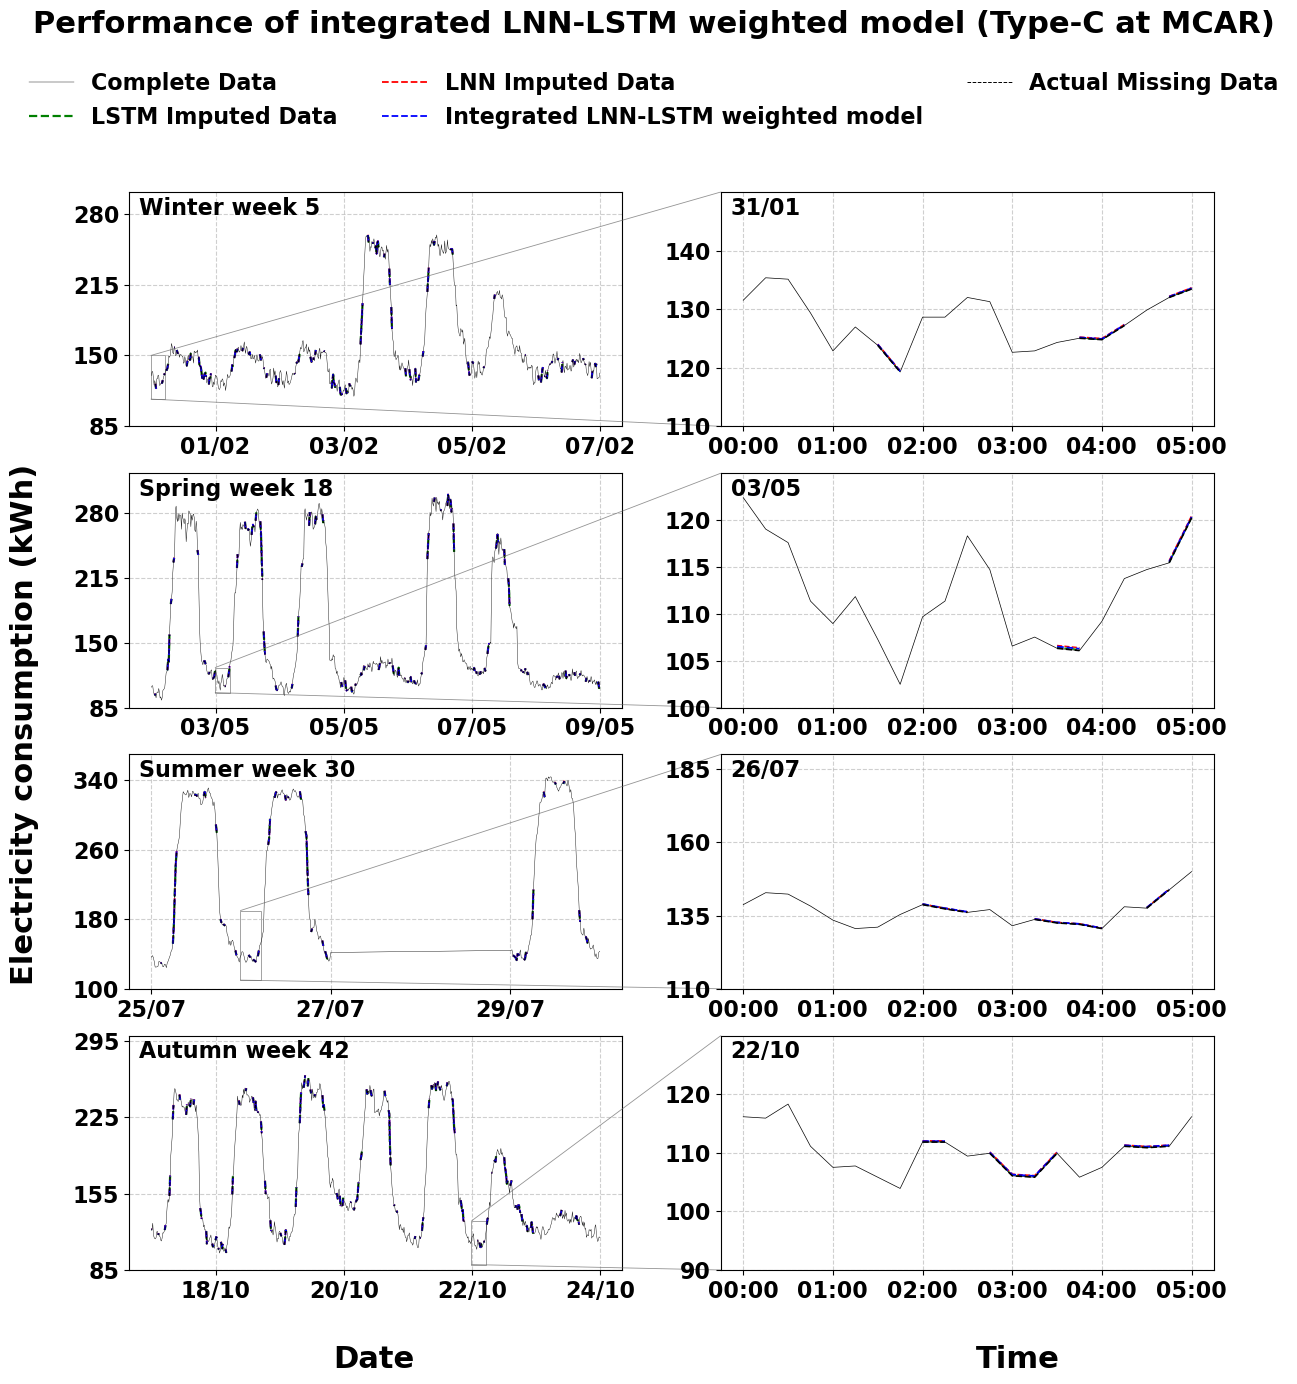

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Load the dataset
file_path = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\505_c1_mcar.csv"
new_data = pd.read_csv(file_path)

# Convert 'datetime' to a datetime object for better handling
new_data['datetime'] = pd.to_datetime(new_data['datetime'], format='%d/%m/%Y %H:%M')
new_data.set_index('datetime', inplace=True)

# Extract week numbers and years for easier aggregation
new_data['year'] = new_data.index.year
new_data['week'] = new_data.index.isocalendar().week

# Define y-axis limits and intervals for each season for weekly and daily plots
y_limits_weekly = {
    'Winter week 5': (85, 300),
    'Spring week 18': (85, 320),
    'Summer week 30': (100, 370),
    'Autumn week 42': (85, 300)
}
y_intervals_weekly = {
    'Winter week 5': 65,
    'Spring week 18': 65,
    'Summer week 30': 80,
    'Autumn week 42': 70
}

y_limits_daily = {
    'Winter week 5': (110, 150),
    'Spring week 18': (100, 125),
    'Summer week 30': (110, 190),
    'Autumn week 42': (90, 130)
}
y_intervals_daily = {
    'Winter week 5': 10,
    'Spring week 18': 5,
    'Summer week 30': 25,
    'Autumn week 42': 10
}

# Define a mapping for each season to plot weekly data and daily data from selected hours (00:00 to 05:00)
season_weeks = {
    'Winter week 5': (2022, 5),
    'Spring week 18': (2022, 18),
    'Summer week 30': (2022, 30),
    'Autumn week 42': (2022, 42)
}

# Parameters to adjust the position and font size of the season labels in the left panel
season_label_params = {
    'x_position': 0.02,  # Horizontal position
    'y_position': 0.98,  # Vertical position
    'font_size': 16      # Font size
}

# Create the figure with 4 rows and 2 columns
fig, axs = plt.subplots(len(season_weeks), 2, figsize=(14, 14), gridspec_kw={'width_ratios': [1, 1]})

# Adjust layout to reduce space between subplots
plt.subplots_adjust(wspace=0.2)

for i, (season, (year, week)) in enumerate(season_weeks.items()):
    weekly_ax = axs[i, 0]
    daily_ax = axs[i, 1]

    # Filter the data for the specified week and year
    seasonal_data = new_data[(new_data['year'] == year) & (new_data['week'] == week)]
    seasonal_data['ytrue_interpolated'] = seasonal_data['ytrue'].interpolate()

    # Weekly plot (left panel)
    weekly_ax.plot(seasonal_data.index, seasonal_data['ytrue_interpolated'], '-', color='black', linewidth=0.3, label='Complete Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LSTM'], '--', color='green', linewidth=1.6, label='LSTM Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN'], '--', color='red', linewidth=1.3, label='LNN Imputed Data')
    weekly_ax.plot(seasonal_data.index, seasonal_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1.3, label='Integrated LNN-LSTM weighted model')
    weekly_ax.plot(seasonal_data.index, seasonal_data['actual data'], '--', color='black', linewidth=0.7, label='Actual Missing Data')

    # Title inside the plot for the weekly panel with customizable position and font size
    weekly_ax.text(season_label_params['x_position'], season_label_params['y_position'], season,
                   transform=weekly_ax.transAxes, fontsize=season_label_params['font_size'], fontweight='bold',
                   verticalalignment='top', horizontalalignment='left')
    weekly_ax.grid(True, linestyle='--', alpha=0.6)
    weekly_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    weekly_ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(weekly_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(weekly_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    y_min_weekly, y_max_weekly = y_limits_weekly[season]
    weekly_ax.set_ylim([y_min_weekly, y_max_weekly])
    weekly_ax.set_yticks(np.arange(y_min_weekly, y_max_weekly, y_intervals_weekly[season]))

    # Daily plot (right panel)
    daily_data = seasonal_data.copy()
    daily_data['day'] = daily_data.index.date
    daily_non_nan_counts = daily_data.groupby('day')['actual data'].apply(lambda x: x.notna().sum())
    selected_day = daily_non_nan_counts.idxmax()

    # Extract data for the selected day (right panel plot)
    selected_day_data = seasonal_data[seasonal_data.index.date == selected_day].between_time('00:00', '05:00')

    # Plot main models and actual data in the daily plot
    daily_ax.plot(selected_day_data.index, selected_day_data['ytrue_interpolated'], '-', color='black', linewidth=0.5, label='Complete Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LSTM'], '--', color='green', linewidth=1, label='LSTM Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN'], '--', color='red', linewidth=1, label='LNN Imputed Data')
    daily_ax.plot(selected_day_data.index, selected_day_data['LNN-LSTM weighted'], '--', color='blue', linewidth=1.3, label='Integrated LNN-LSTM weighted model')
    daily_ax.plot(selected_day_data.index, selected_day_data['actual data'], '--', color='black', linewidth=1.2, label='Actual Missing Data')

    # Insert the date inside the daily plot with Day-Month format
    date_text = pd.Timestamp(selected_day).strftime('%d/%m')  # Day-Month format
    daily_ax.text(0.02, 0.98, date_text, transform=daily_ax.transAxes, fontsize=16, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left')
    daily_ax.grid(True, linestyle='--', alpha=0.6)

    # Set x-axis interval to 1 hour for the daily plot
    daily_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    daily_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(daily_ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16, fontweight='bold')
    plt.setp(daily_ax.yaxis.get_majorticklabels(), fontsize=16, fontweight='bold')

    # Set separate y-axis range and ticks for the daily plot
    y_min_daily, y_max_daily = y_limits_daily[season]
    daily_ax.set_ylim([y_min_daily, y_max_daily])
    daily_ax.set_yticks(np.arange(y_min_daily, y_max_daily, y_intervals_daily[season]))

    # Add inset connection lines
    mark_inset(weekly_ax, daily_ax, loc1=2, loc2=3, fc="none", ec="0.4", alpha=0.7, lw=0.6)

# Common y-axis label
fig.text(0.04, 0.5, 'Electricity consumption (kWh)', va='center', rotation='vertical', fontsize=22, fontweight='bold')

# Common x-axis label
fig.text(0.3, 0.04, 'Date', ha='center', fontsize=22, fontweight='bold')
fig.text(0.76, 0.04, 'Time', ha='center', fontsize=22, fontweight='bold')

# Add suptitle
fig.suptitle('Performance of integrated LNN-LSTM weighted model (Type-C at MCAR)', fontsize=22, fontweight='bold', y=1.01)

# Unified legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False, prop={'weight': 'bold', 'size': 16}, bbox_to_anchor=(0.5, 0.98))

# Adjust layout
plt.tight_layout(rect=[0.07, 0.90, 1, 1])

# Save the plot
output_path_svg = r'C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\type_xc1_mcar.svg'
plt.savefig(output_path_svg, format='svg', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23720\578390657.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_filtered.groupby('month').apply(lambda x: compute_rmse(x['ytrue'], x[column_name]))
C:\Users\user\AppData\Local\Temp\ipykernel_23720\578390657.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_filtered.groupby('month').apply(lambda x: compute_rmse(x['ytrue'], x[column_name])

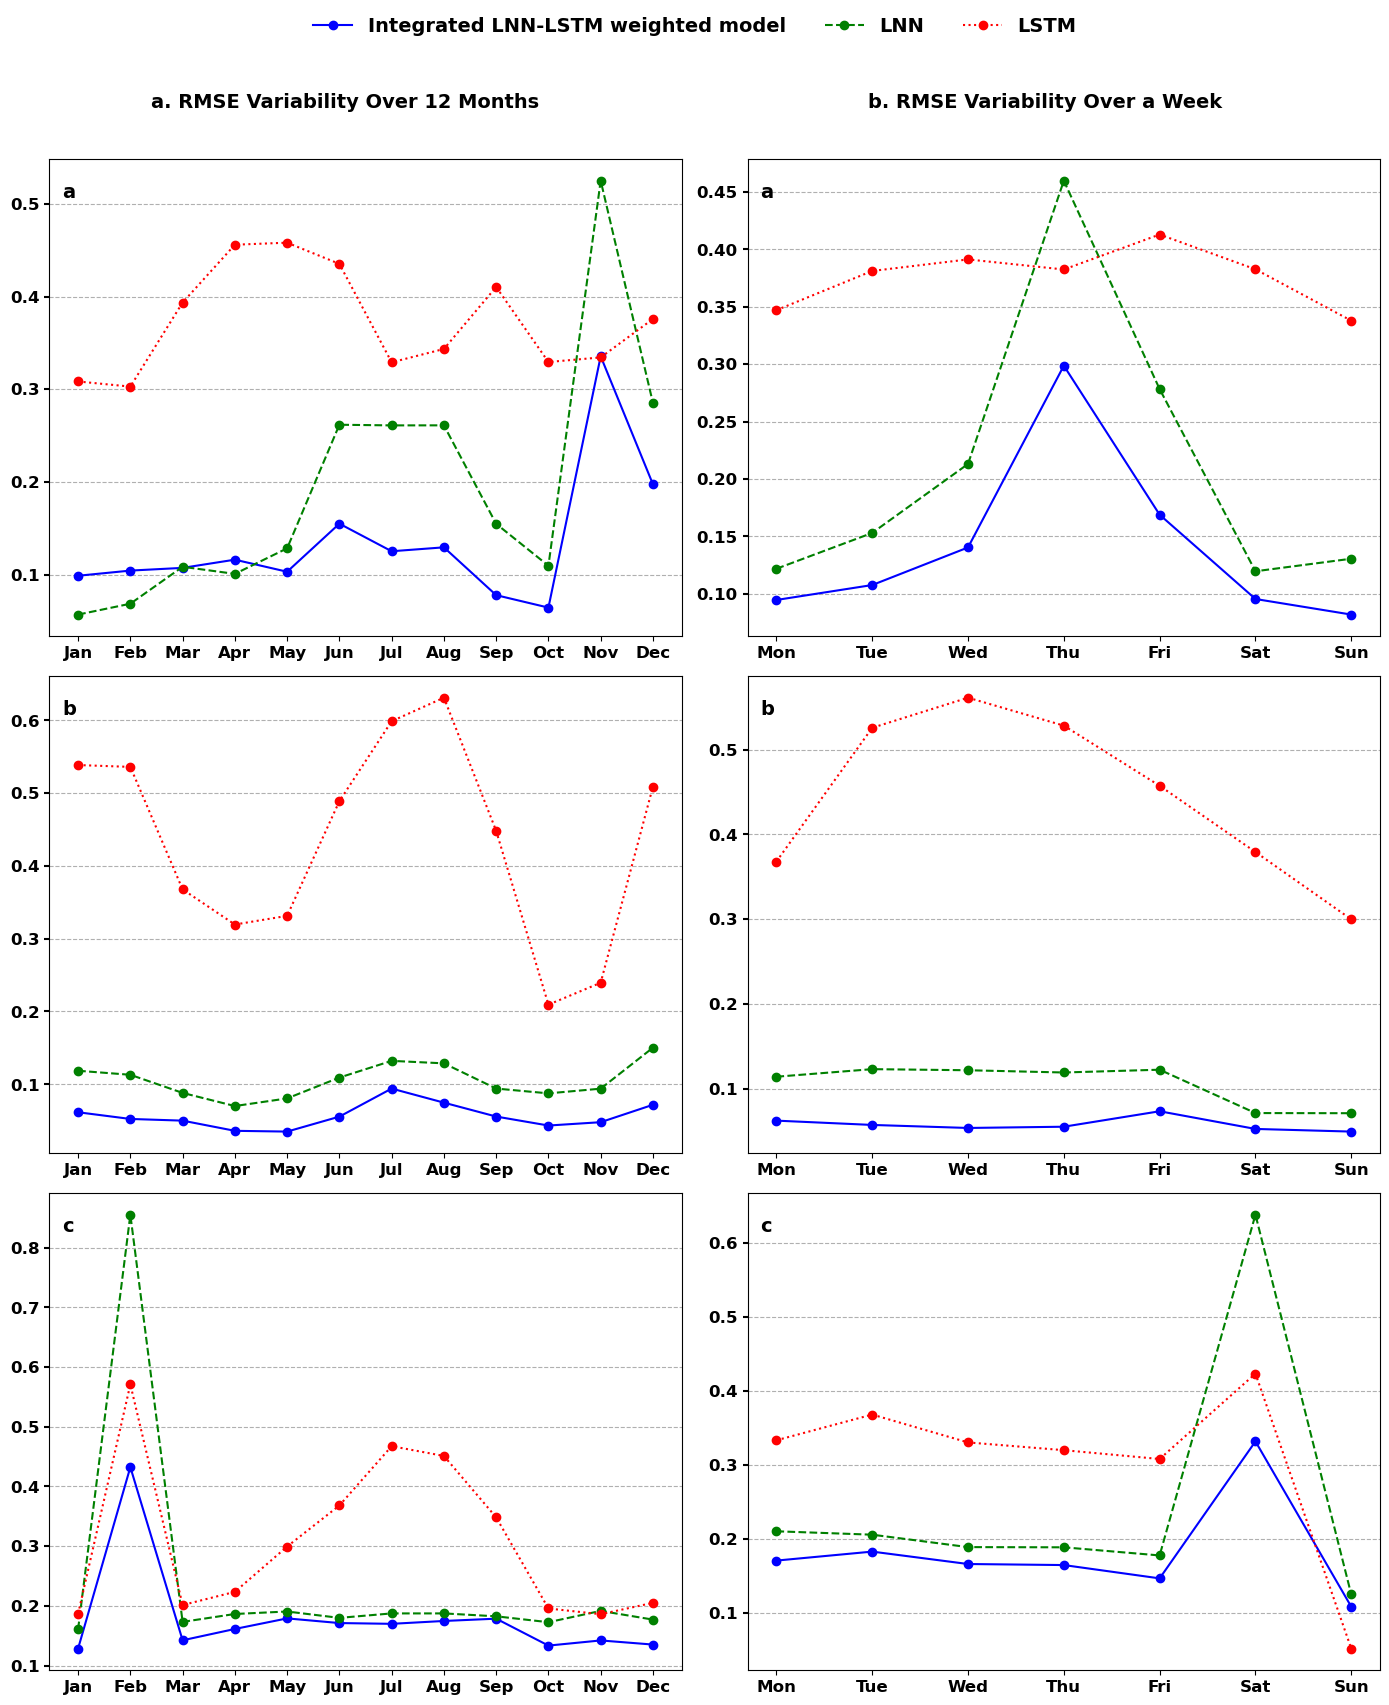

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to compute RMSE
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Paths for the MCAR data files
file_501_mcar = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\Plots for RMSE Variablity\501_Aggregated_Seoul_40.csv"
file_502_mcar = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\Plots for RMSE Variablity\502_Aggregated_Seoul_40.csv"
file_505_mcar = r"C:\Users\user\Desktop\Synology_Friday_backup\LNN-LSTM Paper\Imputed Data\MR_Imputed at_40\Plots for RMSE Variablity\505_Aggregated_Seoul_40.csv"
# Load the MCAR datasets
df_501_mcar = pd.read_csv(file_501_mcar)
df_502_mcar = pd.read_csv(file_502_mcar)
df_505_mcar = pd.read_csv(file_505_mcar)

# Extract the month and day of the week for MCAR datasets
for df in [df_501_mcar, df_502_mcar, df_505_mcar]:
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
    df['month'] = df['datetime'].dt.month
    df['day_of_week'] = df['datetime'].dt.dayofweek

# Filter NaN values for RMSE calculation
df_filtered_501_mcar = df_501_mcar.dropna(subset=['ytrue', '501_Aggregated_40'])
df_filtered_502_mcar = df_502_mcar.dropna(subset=['ytrue', '502_Aggregated_40'])
df_filtered_505_mcar = df_505_mcar.dropna(subset=['ytrue', '505_Aggregated_40'])

df_filtered_501_lnn = df_501_mcar.dropna(subset=['ytrue', '501_LNN_Seoul_40'])
df_filtered_501_lstm = df_501_mcar.dropna(subset=['ytrue', '501_LSTM_Seoul_40'])

df_filtered_502_lnn = df_502_mcar.dropna(subset=['ytrue', '502_LNN_Seoul_40'])
df_filtered_502_lstm = df_502_mcar.dropna(subset=['ytrue', '502_LSTM_Seoul_40'])

df_filtered_505_lnn = df_505_mcar.dropna(subset=['ytrue', '505_LNN_Seoul_40'])
df_filtered_505_lstm = df_505_mcar.dropna(subset=['ytrue', '505_LSTM_Seoul_40'])

# Calculate RMSE per month
def calculate_rmse_monthly(df_filtered, column_name):
    return df_filtered.groupby('month').apply(lambda x: compute_rmse(x['ytrue'], x[column_name]))

rmse_per_month_501 = [calculate_rmse_monthly(df_filtered_501_mcar, '501_Aggregated_40'),
                       calculate_rmse_monthly(df_filtered_501_lnn, '501_LNN_Seoul_40'),
                       calculate_rmse_monthly(df_filtered_501_lstm, '501_LSTM_Seoul_40')]

rmse_per_month_502 = [calculate_rmse_monthly(df_filtered_502_mcar, '502_Aggregated_40'),
                       calculate_rmse_monthly(df_filtered_502_lnn, '502_LNN_Seoul_40'),
                       calculate_rmse_monthly(df_filtered_502_lstm, '502_LSTM_Seoul_40')]

rmse_per_month_505 = [calculate_rmse_monthly(df_filtered_505_mcar, '505_Aggregated_40'),
                       calculate_rmse_monthly(df_filtered_505_lnn, '505_LNN_Seoul_40'),
                       calculate_rmse_monthly(df_filtered_505_lstm, '505_LSTM_Seoul_40')]

# Calculate RMSE per day of the week
def calculate_rmse_weekly(df_filtered, column_name):
    return df_filtered.groupby('day_of_week').apply(lambda x: compute_rmse(x['ytrue'], x[column_name]))

rmse_per_week_501 = [calculate_rmse_weekly(df_filtered_501_mcar, '501_Aggregated_40'),
                      calculate_rmse_weekly(df_filtered_501_lnn, '501_LNN_Seoul_40'),
                      calculate_rmse_weekly(df_filtered_501_lstm, '501_LSTM_Seoul_40')]

rmse_per_week_502 = [calculate_rmse_weekly(df_filtered_502_mcar, '502_Aggregated_40'),
                      calculate_rmse_weekly(df_filtered_502_lnn, '502_LNN_Seoul_40'),
                      calculate_rmse_weekly(df_filtered_502_lstm, '502_LSTM_Seoul_40')]

rmse_per_week_505 = [calculate_rmse_weekly(df_filtered_505_mcar, '505_Aggregated_40'),
                      calculate_rmse_weekly(df_filtered_505_lnn, '505_LNN_Seoul_40'),
                      calculate_rmse_weekly(df_filtered_505_lstm, '505_LSTM_Seoul_40')]

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Define a helper function to plot RMSE
def plot_rmse(ax, monthly_data, weekly_data, plot_label):
    colors = ['blue', 'green', 'red']
    linestyles = ['-', '--', ':']
    markers = ['o', 'o', 'o']  # Use circle markers for all models
    labels = ['Integrated LNN-LSTM weighted model', 'LNN', 'LSTM']

    for i, data in enumerate(monthly_data):
        ax[0].plot(data.index, data.values, color=colors[i], linestyle=linestyles[i], marker=markers[i], label=labels[i])
    ax[0].text(0.02, 0.95, plot_label, transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax[0].set_xticks(np.arange(1, 13))
    ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, fontweight='bold')
    ax[0].grid(axis='y', linestyle='--')  # Horizontal lines only
    ax[0].tick_params(axis='y', labelsize=12, labelcolor='black', width=1.5)
    for label in ax[0].get_yticklabels():
        label.set_fontweight('bold')

    for i, data in enumerate(weekly_data):
        ax[1].plot(data.index, data.values, color=colors[i], linestyle=linestyles[i], marker=markers[i], label=labels[i])
    ax[1].text(0.02, 0.95, plot_label, transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax[1].set_xticks(np.arange(0, 7))
    ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12, fontweight='bold')
    ax[1].grid(axis='y', linestyle='--')  # Horizontal lines only
    ax[1].tick_params(axis='y', labelsize=12, labelcolor='black', width=1.5)
    for label in ax[1].get_yticklabels():
        label.set_fontweight('bold')

plot_rmse(axs[0], rmse_per_month_501, rmse_per_week_501, plot_label='a')
plot_rmse(axs[1], rmse_per_month_502, rmse_per_week_502, plot_label='b')
plot_rmse(axs[2], rmse_per_month_505, rmse_per_week_505, plot_label='c')

# Subtitles and Legend
fig.text(0.25, 0.94, "a. RMSE Variability Over 12 Months", fontsize=14, fontweight='bold', ha='center')
fig.text(0.75, 0.94, "b. RMSE Variability Over a Week", fontsize=14, fontweight='bold', ha='center')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'weight': 'bold', 'size': 14}, frameon=False)

# Save the plot
output_path = r'D:\LNN Based Imputation\datasets\Imputed_Data\rmse_based_on_seasonality_weighted_model/RMSE_Variability_MCAR_Month_Week.svg'
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.savefig(output_path, format='svg')
plt.show()


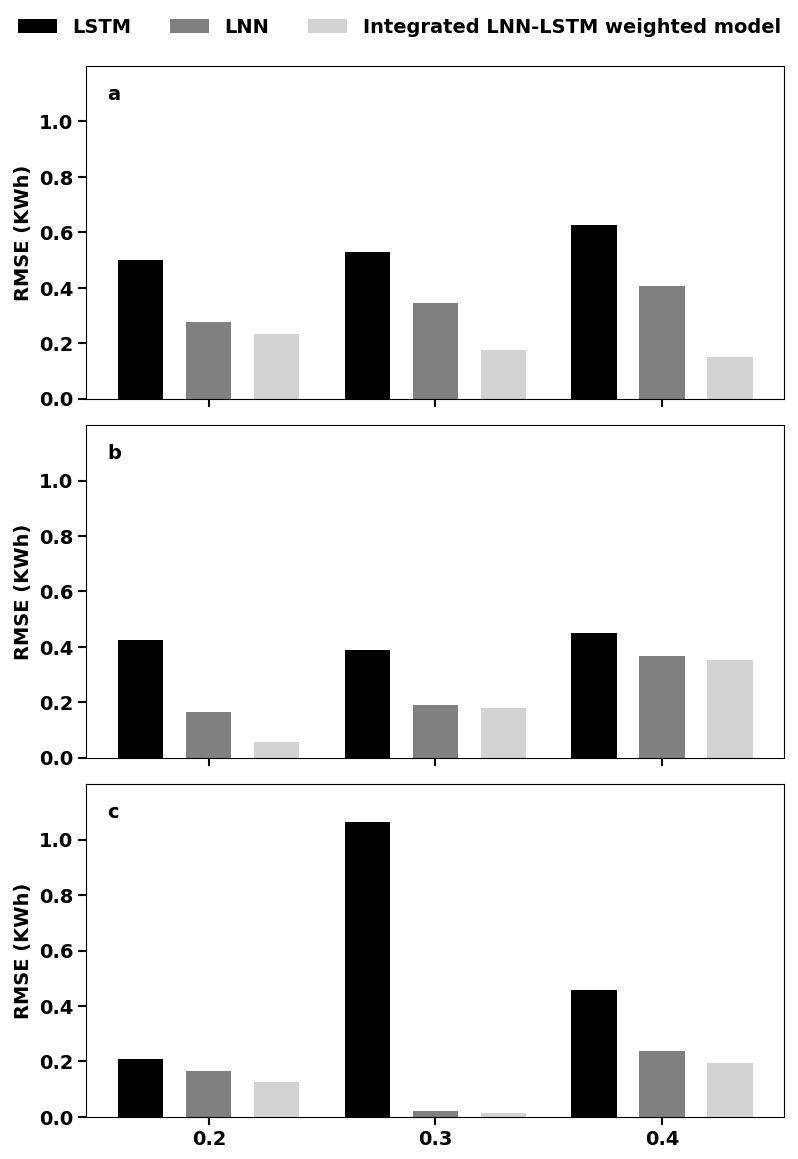

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a function to process and extract relevant data
def process_dataframe(df, building_type):
    df.columns = [
        "Building Type", "Mechanism", "MR", "LSTM Imputer", "LNN Imputer",
        "Weight for LSTM", "Weight for LNN", "LSTM-LNN Weighted RMSE",
        "Over LSTM", "Over LNN"
    ]
    df = df.dropna(subset=["MR"]).reset_index(drop=True)
    df[""] = building_type
    return df

# Load only the MCAR data
file_a_mcar = 'D:/LNN Based Imputation/Imputed Plots/Percentage Improvement/Percentage Improvement MCAR Type A.xlsx'
file_b_mcar = 'D:/LNN Based Imputation/Imputed Plots/Percentage Improvement/Percentage Improvement MCAR Type B.xlsx'
file_c_mcar = 'D:\LNN Based Imputation\Imputed Plots\Percentage Improvement\Percentage Improvement MCAR Type C - Copy.xlsx'

# Read the MCAR Excel files
df_a_mcar = pd.read_excel(file_a_mcar)
df_b_mcar = pd.read_excel(file_b_mcar)
df_c_mcar = pd.read_excel(file_c_mcar)

# Process each DataFrame for MCAR only
df_a_mcar_processed = process_dataframe(df_a_mcar, "Type A")
df_b_mcar_processed = process_dataframe(df_b_mcar, "Type B")
df_c_mcar_processed = process_dataframe(df_c_mcar, "Type C")

# Define a common y-axis limit for all MCAR plots
y_min, y_max = 0, 1.2  # Set y-axis limit to 1.2 but don't display 1.2 at the top

# Define the plotting function
def create_subplot_without_percentage_panel(ax, df_type, title):
    width = 0.3
    x = np.arange(len(df_type["MR"]))

    # Plot each model's RMSE as bars
    bar1 = ax.bar(x - width, df_type["LSTM Imputer"], width / 1.5, label='LSTM', color='black')
    bar2 = ax.bar(x, df_type["LNN Imputer"], width / 1.5, label='LNN', color='gray')
    bar3 = ax.bar(x + width, df_type["LSTM-LNN Weighted RMSE"], width / 1.5, label='Integrated LNN-LSTM weighted model', color='lightgray')

    # Set y-axis limits and adjust y-ticks
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(0, 1.1, 0.2))  # Only show ticks up to 1.0
    ax.set_ylabel('RMSE (KWh)', fontsize=14, fontweight='bold')
    ax.set_yticklabels([f"{tick:.1f}" for tick in np.arange(0, 1.1, 0.2)], fontweight='bold')  # Bold y-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(df_type["MR"], fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)

    # Add the subplot title (a, b, c) at the top-left corner
    ax.text(0.03, 0.90, title, transform=ax.transAxes, fontsize=14, fontweight='bold', ha='left')

# Create subplots for each building type with MCAR mechanism only
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex='col')  # Adjusted figure size

# Define titles for each subplot
titles = ['a', 'b', 'c']
create_subplot_without_percentage_panel(axes[0], df_a_mcar_processed, titles[0])
create_subplot_without_percentage_panel(axes[1], df_b_mcar_processed, titles[1])
create_subplot_without_percentage_panel(axes[2], df_c_mcar_processed, titles[2])

# Create custom legend handles (for one shared legend)
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='none', label='LSTM'),
    plt.Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='none', label='LNN'),
    plt.Rectangle((0, 0), 1, 1, facecolor='lightgray', edgecolor='none', label='Integrated LNN-LSTM weighted model')
]

# Add a main title to the figure
fig.suptitle('', fontsize=14, fontweight='bold', y=1.02)

# Create a single legend for the entire figure, set to bold and larger font size
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, frameon=False, prop={'weight': 'bold', 'size': 14})

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.01, 1, 0.95])  # Adjust layout

# Save the plot as an SVG file
output_svg_path = "D:/LNN Based Imputation/Imputed Plots/Percentage Improvement/lnn_lstm_rmse_mcar_only_modified.svg"
plt.savefig(output_svg_path, format='svg', bbox_inches='tight', dpi=300)
plt.show()
